In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 207.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 200.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [40]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
final_text=""
Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-30:].mean() ,6 )
    print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-30:].mean() ,6 )
    print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
#---------------------------------------------------------------------------
#mail2me_v2(df_tmp_f,"Crypto Bollinger bands",final_text)

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,BTC-USD,16602.585938,17012.468955,16451.594103,-130.839866,-114.204957,Sell
2022-12-31,BTC-USD,16547.496094,16978.676581,16399.597972,-138.131805,-118.990327,Sell
2023-01-01,BTC-USD,16625.080078,16916.05093,16400.250409,-136.081675,-122.408597,Sell
2023-01-02,BTC-USD,16688.470703,16753.113992,16497.091924,-127.867857,-123.500449,Sell
2023-01-03,BTC-USD,16679.857422,16732.028632,16507.515453,-120.662446,-122.932848,Buy
2023-01-04,BTC-USD,16863.238281,16863.943938,16464.361865,-99.013438,-118.148966,Buy
2023-01-07,BTC-USD,16951.228516,17000.604997,16415.954155,-73.904442,-109.300061,Buy


Bol_Up__Mean_for_last_7days   : 17332.427486
Bol_Down__Mean_for_last_7days : 16522.853634
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,ETH-USD,1199.232788,1237.025631,1183.17174,-13.935066,-13.421668,Sell
2022-12-31,ETH-USD,1196.77124,1233.177063,1180.055359,-14.094181,-13.55617,Sell
2023-01-01,ETH-USD,1200.964844,1228.423665,1179.666702,-13.723693,-13.589675,Sell
2023-01-02,ETH-USD,1214.656616,1219.733435,1184.837575,-12.184809,-13.308702,Buy
2023-01-03,ETH-USD,1214.778809,1220.859373,1184.279403,-10.830525,-12.813066,Buy
2023-01-04,ETH-USD,1256.526611,1253.886719,1170.263637,-6.315742,-11.513601,Buy
2023-01-07,ETH-USD,1269.185547,1280.162882,1163.298963,-1.696715,-9.550224,Buy


Bol_Up__Mean_for_last_7days   : 1281.334116
Bol_Down__Mean_for_last_7days : 1183.532132
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,ALGO-USD,0.169008,0.172661,0.163662,-0.01905,-0.020534,Buy
2022-12-31,ALGO-USD,0.172818,0.174522,0.163069,-0.017793,-0.019986,Buy
2023-01-01,ALGO-USD,0.177466,0.178478,0.162426,-0.016234,-0.019235,Buy
2023-01-02,ALGO-USD,0.181194,0.183311,0.160362,-0.01453,-0.018294,Buy
2023-01-03,ALGO-USD,0.184302,0.188491,0.159274,-0.012781,-0.017192,Buy
2023-01-04,ALGO-USD,0.187093,0.19293,0.160508,-0.011043,-0.015962,Buy
2023-01-07,ALGO-USD,0.189463,0.195211,0.165173,-0.009366,-0.014643,Buy


Bol_Up__Mean_for_last_7days   : 0.21034
Bol_Down__Mean_for_last_7days : 0.180347
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,SOL-USD,9.880177,12.314789,8.974379,-1.216004,-1.114807,Sell
2022-12-31,SOL-USD,9.961039,12.002792,8.862593,-1.214312,-1.134708,Sell
2023-01-01,SOL-USD,9.982173,11.57502,8.888728,-1.197462,-1.147259,Sell
2023-01-02,SOL-USD,11.272967,11.552389,8.901746,-1.067644,-1.131336,Buy
2023-01-03,SOL-USD,13.344046,13.243512,7.855942,-0.788554,-1.062779,Buy
2023-01-04,SOL-USD,13.435113,14.406616,7.74404,-0.553643,-0.960952,Buy
2023-01-07,SOL-USD,13.515099,15.13342,8.121041,-0.356906,-0.840143,Buy


Bol_Up__Mean_for_last_7days   : 13.557966
Bol_Down__Mean_for_last_7days : 11.097865
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,LUNC-USD,0.000143,0.000172,0.000133,-0.000006,-0.000008,Buy
2022-12-31,LUNC-USD,0.000145,0.000172,0.000133,-0.000006,-0.000008,Buy
2023-01-01,LUNC-USD,0.00015,0.000172,0.000134,-0.000005,-0.000007,Buy
2023-01-02,LUNC-USD,0.00016,0.000171,0.000134,-0.000004,-0.000007,Buy
2023-01-03,LUNC-USD,0.000156,0.000157,0.000144,-0.000003,-0.000006,Buy
2023-01-04,LUNC-USD,0.000158,0.00016,0.000143,-0.000003,-0.000005,Buy
2023-01-07,LUNC-USD,0.000156,0.000161,0.000144,-0.000002,-0.000005,Buy


Bol_Up__Mean_for_last_7days   : 0.000167
Bol_Down__Mean_for_last_7days : 0.000143
ROSE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ROSE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,ROSE-USD,0.03394,0.037094,0.033599,-0.00282,-0.002931,Buy
2022-12-31,ROSE-USD,0.03418,0.037137,0.033223,-0.00276,-0.002897,Buy
2023-01-01,ROSE-USD,0.034853,0.037078,0.033146,-0.002629,-0.002843,Buy
2023-01-02,ROSE-USD,0.035778,0.036751,0.033291,-0.002422,-0.002759,Buy
2023-01-03,ROSE-USD,0.035716,0.036485,0.033417,-0.002237,-0.002654,Buy
2023-01-04,ROSE-USD,0.036692,0.037089,0.033113,-0.001988,-0.002521,Buy
2023-01-07,ROSE-USD,0.037114,0.037881,0.033054,-0.001738,-0.002364,Buy


Bol_Up__Mean_for_last_7days   : 0.042073
Bol_Down__Mean_for_last_7days : 0.036545
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2022-12-31,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-01,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-02,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-03,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-04,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-07,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy


Bol_Up__Mean_for_last_7days   : 9e-06
Bol_Down__Mean_for_last_7days : 8e-06
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,XRP-USD,0.345017,0.373988,0.333673,-0.009784,-0.010328,Buy
2022-12-31,XRP-USD,0.339929,0.374863,0.329298,-0.010245,-0.010311,Buy
2023-01-01,XRP-USD,0.338763,0.375692,0.326289,-0.010582,-0.010365,Sell
2023-01-02,XRP-USD,0.348556,0.369547,0.32753,-0.009945,-0.010281,Buy
2023-01-03,XRP-USD,0.343824,0.357073,0.333061,-0.009709,-0.010167,Buy
2023-01-04,XRP-USD,0.347794,0.351181,0.336456,-0.009098,-0.009953,Buy
2023-01-07,XRP-USD,0.344543,0.351386,0.336736,-0.008774,-0.009717,Buy


Bol_Up__Mean_for_last_7days   : 0.382004
Bol_Down__Mean_for_last_7days : 0.348487
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2022-12-30,ADA-USD,0.245557,0.271402,0.23785,-0.016982,-0.016857,Sell
2022-12-31,ADA-USD,0.246466,0.269958,0.235608,-0.016695,-0.016825,Buy
2023-01-01,ADA-USD,0.249771,0.267685,0.235166,-0.016016,-0.016663,Buy
2023-01-02,ADA-USD,0.253828,0.261075,0.238499,-0.014978,-0.016326,Buy
2023-01-03,ADA-USD,0.252796,0.256008,0.241403,-0.014077,-0.015876,Buy
2023-01-04,ADA-USD,0.267677,0.267516,0.235408,-0.012023,-0.015106,Buy
2023-01-07,ADA-USD,0.278566,0.280852,0.231909,-0.009408,-0.013966,Buy


Bol_Up__Mean_for_last_7days   : 0.295604
Bol_Down__Mean_for_last_7days : 0.262008


In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

for cp in getCryptoPairs():
    print(cp)

BTC-USD
ETH-USD
BNB-USD
XRP-USD
BUSD-USD
DOGE-USD
ADA-USD
MATIC-USD


In [8]:
Crypto_Pairs=["BTC-USD","ETH-USD"]

message_input=""
final_message=""
for cp in Crypto_Pairs:
    print(cp)
    df_tmp=getRates(cp,  '3mo',  '1h')
    message_input=cp+"   First: "+str( round( df_tmp.head(1)[0] ,6 ) )+"  "+"Last: "+str( round(df_tmp.tail(1)[0] ,6)  )
    df3mo=getRates(cp,  '3mo',  '1h')
    message_input0=cp+"  '3mo',  '1h' CHANGE % " +str( getPercChange(df3mo)[0])
    
    df1mo=getRates(cp,  '1mo',  '1h')
    message_input1=cp+"  '1mo',  '1h' CHANGE % " +str( getPercChange(df1mo)[0])
    
    dfwk=getRates(cp,'1wk',  '1h')
    message_input2=cp+"  '1wk',  '1h' CHANGE % " +str( getPercChange(dfwk)[0])
    
    message_input=message_input+"\n"+message_input0+"\n"+message_input1+"\n"+message_input2+"\n"+"\n"
    final_message=final_message+message_input
    print(final_message)
    
    
#mail2me("All Crypto Pairs",final_message)

BTC-USD
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 19952.896484  Last: 16963.009766
BTC-USD  '3mo',  '1h' CHANGE % -14.9847
BTC-USD  '1mo',  '1h' CHANGE % -0.7515
BTC-USD  '1wk',  '1h' CHANGE % 2.1756


ETH-USD
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 19952.896484  Last: 16963.009766
BTC-USD  '3mo',  '1h' CHANGE % -14.9847
BTC-USD  '1mo',  '1h' CHANGE % -0.7515
BTC-USD  '1wk'

In [9]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

dfx=getRatesTable(*Crypto_Pairs)

dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[*********************100%***********************]  1 of 1 completed
XRP-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3mo 1

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,3609.1074,-3.2178,118.3361,-60.6982,-14.9847,-0.7515,2.1756,0.6056
1,ETH-USD,295.7172,21.8986,779.9423,-62.8543,-6.0467,-0.1675,5.8854,1.1977
2,ALGO-USD,-94.0756,-94.0756,-21.6738,-87.8942,-45.6029,-18.9848,12.2771,2.6748
3,SOL-USD,1305.4245,1305.4245,1305.4245,-91.1147,-59.9100,-6.4743,35.2894,-0.9421
4,LUNC-USD,-99.9881,-99.9881,-99.9309,-99.9998,-42.6471,-9.3023,9.0909,1.2987
5,ROSE-USD,-2.8196,-2.8196,-2.8196,-90.6695,-37.3587,-19.4689,9.3727,1.8186
6,SHIB-USD,inf,inf,inf,-74.1935,-27.2727,-11.1111,0.0000,0.0000
7,XRP-USD,58.6124,-88.8505,55.7325,-55.8502,-30.0564,-12.0398,-0.0162,1.3673
8,ADA-USD,767.2137,-72.9379,645.7824,-78.2801,-35.1559,-12.7328,13.1994,1.4156


In [10]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

In [12]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()

ETH-USD 1d 1h
[*********************100%***********************]  1 of 1 completed


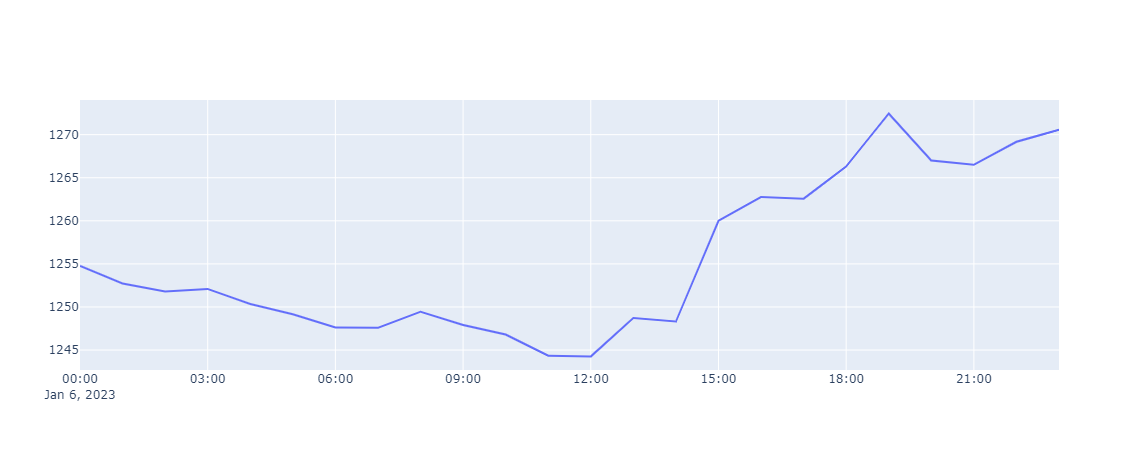

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


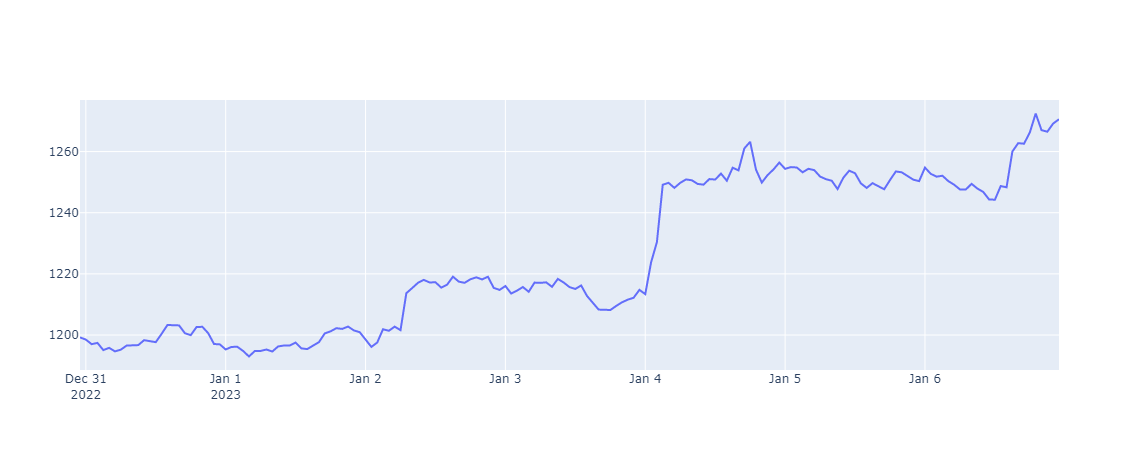

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


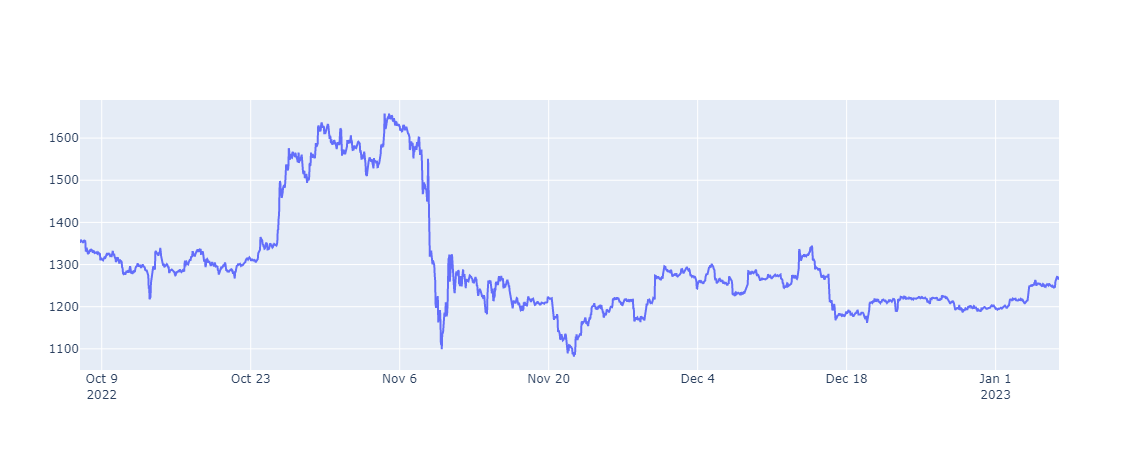

ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed


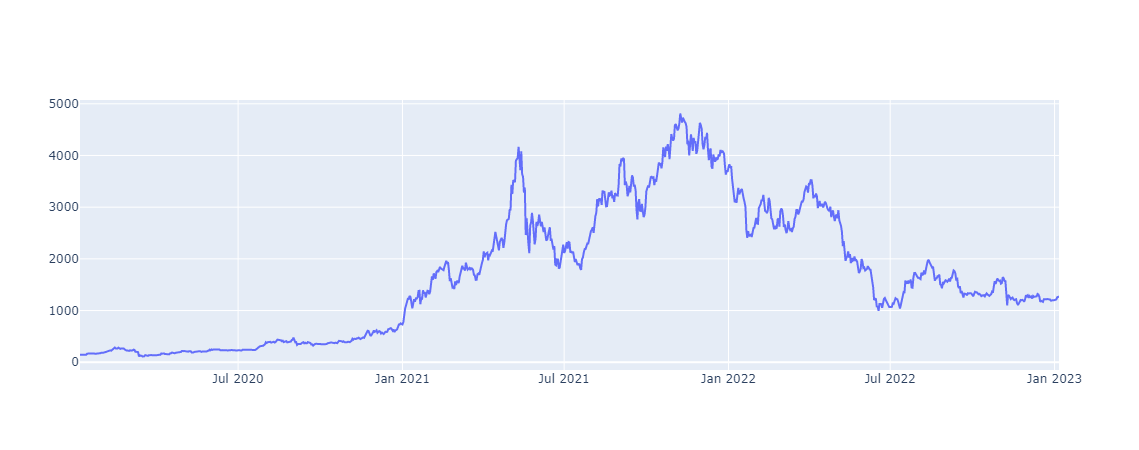

In [13]:
( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
( getLine(getRates('ETH-USD',  '3y',  '1d')) )